# Note: The n-term dataset used here is not the final n-term dataset. Results are not directly comparable.

In [1]:
import sys
sys.path.append('../denoise/')

import os
import math
import pickle
import random
import numpy as np
from time import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.parametrizations import spectral_norm

import matplotlib.pyplot as plt
%matplotlib inline

from divide_mix.data_handling import CleavageLoader
from divide_mix.train_utils import (
    NegEntropy,
    SemiLoss,
    warmup,
    train,
    evaluate,
    process_gmm
)

In [2]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(1234)

In [3]:
# number of trainable parameters in model
def get_total_model_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def gelu(x):
    """
    Facebook Research implementation of the gelu activation function.
    
    For information: OpenAI GPT's gelu is slightly different
    (and gives slightly different results):
    0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))
    """
    return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

In [4]:
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, rnn_size1, rnn_size2, hidden_size, dropout1, dropout2):
        super().__init__()
        
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
        )
        
        self.dropout1=nn.Dropout(dropout1)
        self.dropout2=nn.Dropout(dropout2)
        
        self.lstm1 = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=rnn_size1,
            bidirectional=True,
            batch_first=True,
        )

        self.lstm2 = nn.LSTM(
            input_size=2 * rnn_size1,
            hidden_size=rnn_size2,
            bidirectional=True,
            batch_first=True,
        )
        
        self.fc1 = spectral_norm(nn.Linear(rnn_size2 * 2, hidden_size))
        self.fc2 = nn.Linear(hidden_size, 2)
        
    
    def no_embed_fw(self, embedded):
        # input shape: (batch_size, seq_len, embedding_dim)
        out, _ = self.lstm1(embedded)
        
        # input shape: (batch_size, seq_len, 2*rnn_size1)
        out, _ = self.lstm2(out)
        
        # input shape: (batch_size, seq_len, 2*hidden_size)
        pooled, _ = torch.max(out, dim=1)
        
        # input shape: (batch_size, 2*hidden_size)
        out = self.dropout1(gelu(self.fc1(pooled)))
        
        # input shape: (batch_size, hidden_size)
        # output shape: (batch_size, 2)
        return self.fc2(out)
    
    def forward(self, seq, seq2=None, lam=None, interpolate=False):
        if interpolate:
            # input shape: (batch_size, seq_len=10)
            embedded1 = self.embedding(seq)
            embedded2 = self.embedding(seq2)
            embedded_mixed = lam * embedded1 + (1 - lam) * embedded2
            return self.no_embed_fw(self.dropout2(embedded_mixed))
        else:
            # input shape: (batch_size, seq_len=10)
            embedded = self.dropout1(self.embedding(seq))
            return self.no_embed_fw(embedded)

In [5]:
BATCH_SIZE = 64
LR = 5e-5
ALPHA = 0.5
LAMBDA_U = 25
P_THRESHOLD = 0.5
TEMPERATURE = 0.5
NUM_EPOCHS = 10
NUM_WARM_UP_EPOCHS = 1
RAMPUP_LEN = 5
NUM_CLASSES = 2

vocab = torch.load('../data/vocab.pt')
device = "cuda:0" if torch.cuda.is_available() else "cpu"
beta_dist = torch.distributions.beta.Beta(ALPHA, ALPHA)
loader = CleavageLoader(batch_size=BATCH_SIZE, num_workers=10)

In [6]:
model1 = BiLSTM(
    vocab_size=len(vocab),
    embedding_dim=200,
    rnn_size1=256,
    rnn_size2=512,
    hidden_size=128,
    dropout1=0.5,
    dropout2=0.
).to(device)

model2 = BiLSTM(
    vocab_size=len(vocab),
    embedding_dim=20,
    rnn_size1=256,
    rnn_size2=512,
    hidden_size=128,
    dropout1=0.5,
    dropout2=0.
).to(device)

optimizer1 = optim.Adam(model1.parameters(), lr=LR)
optimizer2 = optim.Adam(model2.parameters(), lr=LR)

criterion = SemiLoss()
conf_penalty = NegEntropy()
CEloss = nn.CrossEntropyLoss()
CE = nn.CrossEntropyLoss(reduction="none")

In [7]:
warmup_loader = loader.load(terminus="n", mode="warmup")
train_gmm_loader = loader.load(terminus="n", mode="divide_by_GMM")
eval_loader = loader.load(terminus="n", mode="evaluate")

start = time()
highest_val_auc = 0
for epoch in range(1, NUM_EPOCHS + 1):
    if epoch < NUM_WARM_UP_EPOCHS + 1:
        # run warm up model 1 and 2 while adding penalty for confident predictions
        warmup_loss1, warmup_acc1, warmup_auc1 = warmup(
            model=model1,
            optimizer=optimizer1,
            loss_func=CEloss,
            conf_penalty=conf_penalty,
            dataloader=warmup_loader
        )
        warmup_loss2, warmup_acc2, warmup_auc2 = warmup(
            model=model2,
            optimizer=optimizer2,
            loss_func=CEloss,
            conf_penalty=conf_penalty,
            dataloader=warmup_loader
        )

        print(
            f"Warm-Up Model1: [Epoch {epoch:2d}, Loss: {warmup_loss1:8.6f}, Acc: {warmup_acc1:.4f}, AUC: {warmup_auc1:.4f}]"
        )
        print(
            f"Warm-Up Model2: [Epoch {epoch:2d}, Loss: {warmup_loss2:8.6f}, Acc: {warmup_acc2:.4f}, AUC: {warmup_auc2:.4f}]"
        )
        
        # evaluate on dev set
        val_acc, val_auc, val_loss = evaluate(
            model1=model1,
            model2=model2,
            loss_func=CE,
            dataloader=eval_loader
        )
        print(
            f"Evaluation Set: [Epoch {epoch:2d}, Loss: {val_loss:.6f}, Acc: {val_acc:.4f}, AUC: {val_auc:.4f}]"
        )

    else:
        prob1, train_loss1, raw_losses1, norm_losses1 = process_gmm(model1, train_gmm_loader, CE)
        prob2, train_loss2, raw_losses2, norm_losses2 = process_gmm(model2, train_gmm_loader, CE)

        pred1 = prob1 > P_THRESHOLD
        pred2 = prob2 > P_THRESHOLD

        
        print(f'pred1 clean: {pred1.sum()}, pred1 noisy: {(~pred1).sum()}, total: {len(pred1)}')
        print(f'pred2 clean: {pred2.sum()}, pred2 noisy: {(~pred2).sum()}, total: {len(pred2)}')
        
        # train both models
        labeled_trainloader, unlabeled_trainloader = loader.load(
            terminus="n", mode="train", pred=pred2, prob=prob2
        )
        
        print(f'length of clean dataset based on pred2: {len(labeled_trainloader.dataset)}')
        print(f'length of noisy dataset based on pred2: {len(unlabeled_trainloader.dataset)}')
        
        divmix_loss1 = train(
            epoch=epoch,
            model1=model1,
            model2=model2,
            optimizer=optimizer1,
            loss_func=criterion,
            num_warm_up_epochs=NUM_WARM_UP_EPOCHS,
            num_classes=NUM_CLASSES,
            lambda_u=LAMBDA_U,
            temp=TEMPERATURE,
            beta_dist=beta_dist,
            batch_size=BATCH_SIZE,
            labeled_loader=labeled_trainloader,
            unlabeled_loader=unlabeled_trainloader,
            rampup_len=RAMPUP_LEN,
            named_model="model1"
        )

        labeled_trainloader, unlabeled_trainloader = loader.load(
            terminus="n", mode="train", pred=pred1, prob=prob1
        )
        
        print(f'length of clean dataset based on pred1: {len(labeled_trainloader.dataset)}')
        print(f'length of noisy dataset based on pred1: {len(unlabeled_trainloader.dataset)}')
        
        
        divmix_loss2 = train(
            epoch=epoch,
            model1=model2,
            model2=model1,
            optimizer=optimizer2,
            loss_func=criterion,
            num_warm_up_epochs=NUM_WARM_UP_EPOCHS,
            num_classes=NUM_CLASSES,
            lambda_u=LAMBDA_U,
            temp=TEMPERATURE,
            beta_dist=beta_dist,
            batch_size=BATCH_SIZE,
            labeled_loader=labeled_trainloader,
            unlabeled_loader=unlabeled_trainloader,
            rampup_len=RAMPUP_LEN,
            named_model="model2"
        )

        # evaluate on dev set
        val_acc, val_auc, val_loss = evaluate(
            model1=model1,
            model2=model2,
            loss_func=CE,
            dataloader=eval_loader
        )

        # if val_auc > highest_val_auc:
        #     highest_val_auc = val_auc
        #     path1 = f"../params/n_term/BiLSTM/auc{val_auc:.4f}_epoch{epoch}_model1.pt"
        #     path2 = f"../params/n_term/BiLSTM/auc{val_auc:.4f}_epoch{epoch}_model2.pt"
        #     torch.save(model1.state_dict(), path1)
        #     torch.save(model2.state_dict(), path2)

        print(
            f"Training Set: [Epoch {epoch:2d}, Loss1: {train_loss1:.6f}, Loss2: {train_loss2:.6f}]"
        )
        print(
            f"DivideMix Training: [Epoch {epoch:2d}, Loss1: {divmix_loss1:.6f}, Loss2: {divmix_loss2:.6f}]"
        )
        print(
            f"Evaluation Set: [Epoch {epoch:2d}, Loss: {val_loss:.6f}, Acc: {val_acc:.4f}, AUC: {val_auc:.4f}]"
        )

    if epoch == 2: # first epoch after warmup
        epoch1_raw_losses1, epoch1_norm_losses1 = raw_losses1, norm_losses1
        epoch1_raw_losses2, epoch1_norm_losses2 = raw_losses2, norm_losses2
        epoch1_prob1, epoch1_prob2 = prob1, prob2
        epoch1_pred1, epoch1_pred2 = pred1, pred2
    elif epoch == 5:
        epoch5_raw_losses1, epoch5_norm_losses1 = raw_losses1, norm_losses1
        epoch5_raw_losses2, epoch5_norm_losses2 = raw_losses2, norm_losses2
        epoch5_prob1, epoch5_prob2 = prob1, prob2
        epoch5_pred1, epoch5_pred2 = pred1, pred2
    elif epoch == 10:
        epoch10_raw_losses1, epoch10_norm_losses1 = raw_losses1, norm_losses1
        epoch10_raw_losses2, epoch10_norm_losses2 = raw_losses2, norm_losses2
        epoch10_prob1, epoch10_prob2 = prob1, prob2
        epoch10_pred1, epoch10_pred2 = pred1, pred2


print("Finished Training.")
train_time = (time() - start) / 60
print(f"Training took {train_time} minute.")

warmup: 100%|██████████████████████████████████████████████████| 2236/2236 [00:19<00:00, 116.02batches/s]
Warm-Up Model1: [Epoch  1, Loss: -0.000036, Acc: 0.6033, AUC: 0.6193]
Warm-Up Model2: [Epoch  1, Loss: -0.000026, Acc: 0.5907, AUC: 0.5887]
evaluate: 100%|███████████████████████████████████████████████████| 140/140 [00:01<00:00, 88.75batches/s]
Evaluation Set: [Epoch  1, Loss: 0.589756, Acc: 0.6788, AUC: 0.7463]
GMM processing: 100%|██████████████████████████████████████████| 1118/1118 [00:05<00:00, 209.05batches/s]
pred1 clean: 680629, pred1 noisy: 463837, total: 1144466
pred2 clean: 373499, pred2 noisy: 770967, total: 1144466
length of clean dataset based on pred2: 373499
length of noisy dataset based on pred2: 770967
train model1: 100%|█████████████████████████████████████████████| 5836/5836 [01:03<00:00, 92.11batches/s]
length of clean dataset based on pred1: 680629
length of noisy dataset based on pred1: 463837
evaluate: 100%|██████████████████████████████████████████████████

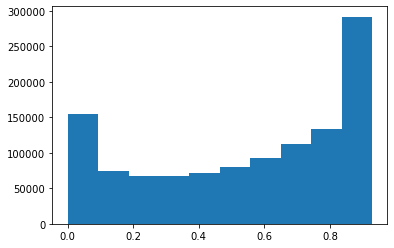

In [8]:
plt.hist(epoch1_prob1)
plt.show()

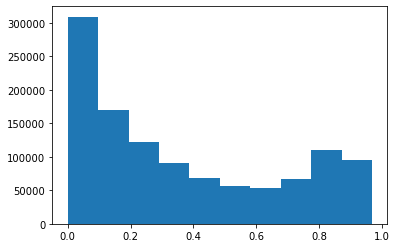

In [9]:
plt.hist(epoch1_prob2)
plt.show()

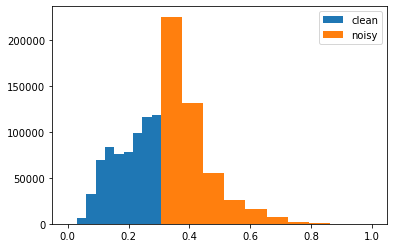

In [10]:
plt.hist(epoch1_norm_losses1[epoch1_pred1], label='clean')
plt.hist(epoch1_norm_losses1[~epoch1_pred1], label='noisy')
plt.legend()
plt.show()

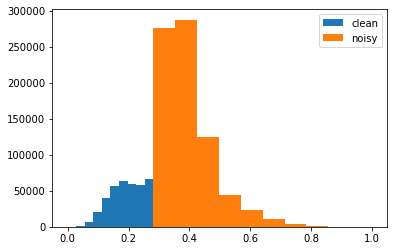

In [11]:
plt.hist(epoch1_norm_losses2[epoch1_pred2], label='clean')
plt.hist(epoch1_norm_losses2[~epoch1_pred2], label='noisy')
plt.legend()
plt.show()

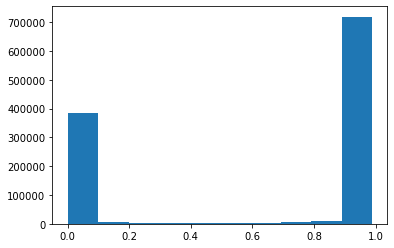

In [12]:
plt.hist(epoch5_prob1)
plt.show()

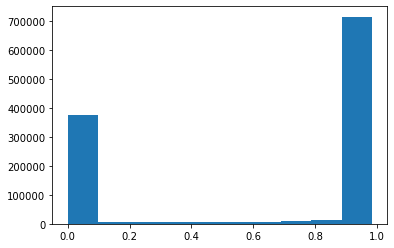

In [13]:
plt.hist(epoch5_prob2)
plt.show()

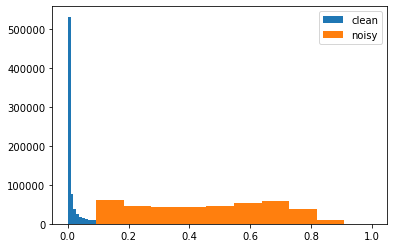

In [14]:
plt.hist(epoch5_norm_losses1[epoch5_pred1], label='clean')
plt.hist(epoch5_norm_losses1[~epoch5_pred1], label='noisy')
plt.legend()
plt.show()

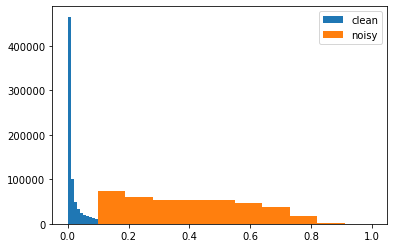

In [15]:
plt.hist(epoch5_norm_losses2[epoch5_pred2], label='clean')
plt.hist(epoch5_norm_losses2[~epoch5_pred2], label='noisy')
plt.legend()
plt.show()

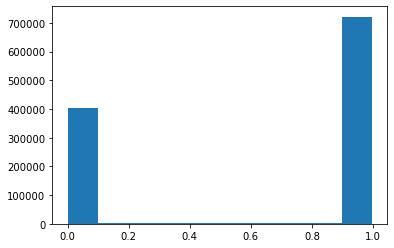

In [16]:
plt.hist(epoch10_prob1)
plt.show()

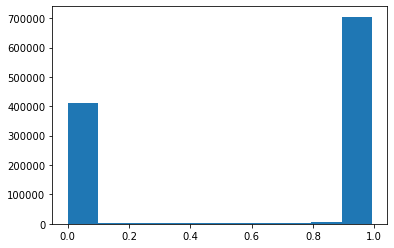

In [17]:
plt.hist(epoch10_prob2)
plt.show()

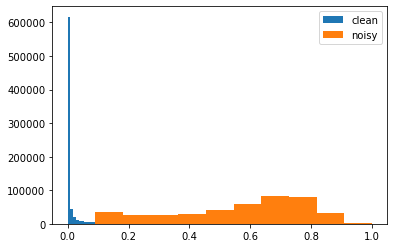

In [18]:
plt.hist(epoch10_norm_losses1[epoch10_pred1], label='clean')
plt.hist(epoch10_norm_losses1[~epoch10_pred1], label='noisy')
plt.legend()
plt.show()

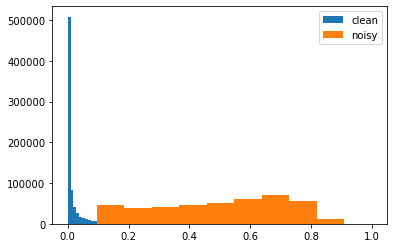

In [19]:
plt.hist(epoch10_norm_losses2[epoch10_pred2], label='clean')
plt.hist(epoch10_norm_losses2[~epoch10_pred2], label='noisy')
plt.legend()
plt.show()